# Import libraries

In [1]:
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Progbar

### Some constants ###
lr = 1e-4
batch_size = 1
epochs = 5
img_shape = (256, 256, 3)
latent_dim = 100
buffer_size = 1000

### Discriminators and Generators weights path ###
g_weights_path = "weights/g.weights.hdf5" # G : X -> Y
f_weights_path = "weights/f.weights.hdf5" # F : Y -> X
x_weights_path = "weights/x.weights.hdf5" # discriminate X and F(Y)
y_weights_path = "weights/y.weights.hdf5" # discriminate Y and G(X)

# Loading and processing data

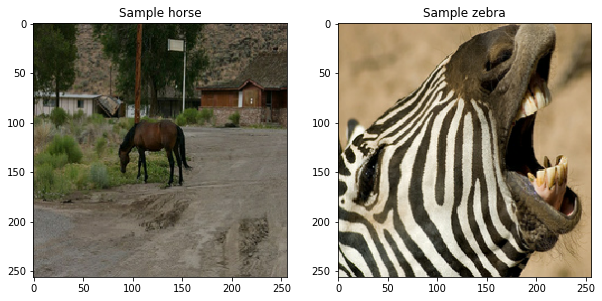

In [2]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB'] 
train_size = min(len(list(train_horses)), len(list(train_zebras)))
test_size  = min(len(list(test_horses)), len(list(test_zebras)))

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[img_shape[0], img_shape[1], 3])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 112 x 112 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image 

train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(
    buffer_size).batch(batch_size)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
img1 = next(iter(train_horses)).numpy()[0] * 127.5 + 127.5
img1 = img1.astype(np.uint8)
ax[0].imshow(img1)
ax[0].set_title("Sample horse")

img2 = next(iter(train_zebras)).numpy()[0] * 127.5 + 127.5
img2 = img2.astype(np.uint8)
ax[1].imshow(img2)
ax[1].set_title("Sample zebra")

plt.show()

# Model architectures

## 1. Generator G and F

In [3]:
# def make_generator(name):
#     inputs = Input(shape=(latent_dim,))
    
#     x = Dense(7*7*256, use_bias=False)(inputs)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     x = Reshape(target_shape=(7,7,256))(x)
    
#     # Size = 128 x 14 x 14 
#     x = Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same',
#                         use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 64 x 28 x 28
#     x = Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 32 x 56 x 56
#     x = Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Size = 16 x 112 x 112
#     x = Conv2DTranspose(16, kernel_size=(4,4), strides=(2,2), padding='same',
#                        use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
#     # Use tanh so that it is [-1, 1]
#     x = Conv2D(img_shape[-1], kernel_size=(4,4), padding='same', use_bias=False, activation='tanh')(x)
    
#     model = Model(inputs=inputs, outputs=x, name=f'Generator_{name}')
#     return model

G = pix2pix.unet_generator(img_shape[-1], norm_type='instancenorm') # make_generator('G')
F = pix2pix.unet_generator(img_shape[-1], norm_type='instancenorm') # make_generator('F')

print(G.summary())
print(F.summary())


if(os.path.exists(x_weights_path) 
   and os.path.exists(y_weights_path)
   and os.path.exists(g_weights_path)
   and os.path.exists(f_weights_path)):
    print('[INFO] Loading weights for generators ...')
    G.load_weights(g_weights_path)
    F.load_weights(f_weights_path)
    

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 2 524800      sequential_1[0][0]               
_______________________________________________________________________________________

## Discriminator X and Y

In [4]:
# def make_discriminator(name):
#     inputs = Input(shape=img_shape)
    
#     x = Conv2D(16, kernel_size=(4,4), strides=(2,2), padding='same')(inputs)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
    
#     x = Flatten()(x)
#     x = Dense(1)(x)
    
#     model = Model(inputs=inputs, outputs=x, name=f'Discriminator_{name}')
#     return model

D_x = pix2pix.discriminator(norm_type='instancenorm', target=False) # make_discriminator("X")
D_y = pix2pix.discriminator(norm_type='instancenorm', target=False) # make_discriminator("Y")

print(D_x.summary())
print(D_y.summary())

if(os.path.exists(x_weights_path) 
   and os.path.exists(y_weights_path)
   and os.path.exists(g_weights_path)
   and os.path.exists(f_weights_path)):
    print('[INFO] Loading weights for discriminators ...')
    D_x.load_weights(x_weights_path)
    D_y.load_weights(y_weights_path)
    

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_30 (Sequential)   (None, None, None, 64)    3072      
_________________________________________________________________
sequential_31 (Sequential)   (None, None, None, 128)   131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 256)   0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_30 (I (None, None, None, 512)  

# Define loss functions 

In [5]:
bce = BinaryCrossentropy(from_logits=True)
LAMBDA = 10.0 # scale factor for cycle consistency and identity loss functions

def generator_loss(D_fake):
    ones = tf.ones_like(D_fake, dtype=tf.float32)
    loss = bce(ones, D_fake)
    
    return loss

def discriminator_loss(D_real, D_fake):
    ones = tf.ones_like(D_real, dtype=tf.float32)
    zeros = tf.zeros_like(D_fake, dtype=tf.float32)
    
    real_loss = bce(ones, D_real)
    fake_loss = bce(zeros, D_fake)
    loss = real_loss + fake_loss
    
    return loss

def cycle_consistency_loss(cycled_images, real_images):
    return LAMBDA * tf.reduce_mean(tf.abs(cycled_images - real_images))

def identity_loss(same_images, real_images):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(same_images - real_images))

# Define training loop

In [6]:
### Preparing optimizers ###
g_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
f_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
x_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)
y_opt = Adam(lr=lr, beta_1=0.5, amsgrad=True)

@tf.function
def train_step(X, Y):
    ### F : Y -> X, G : X -> Y ###
    ### X : separate X and F(Y), Y : separate Y and G(X) ###
    with tf.GradientTape(persistent=True) as tape:
        # For binary crossentropy 
        fake_y = G(X, training=True)
        fake_x = F(Y, training=True)
        
        # For cycle consistency losses 
        cycled_y = F(fake_y, training=True)
        cycled_x = G(fake_x, training=True)
        
        # For identity losses 
        same_x   = F(X, training=True)
        same_y   = G(Y, training=True)
        
        D_X_real = D_x(X, training=True)
        D_Y_real = D_y(Y, training=True)
        D_X_fake = D_x(fake_x, training=True)
        D_Y_fake = D_y(fake_y, training=True)
        
        # Training generators
        bce_g = generator_loss(D_Y_fake)
        bce_f = generator_loss(D_X_fake)
        
        total_cycle_loss = cycle_consistency_loss(cycled_x, X) + cycle_consistency_loss(cycled_y, Y)
        
        identity_g = identity_loss(same_y, Y)
        identity_f = identity_loss(same_x, X)
        
        total_loss_g = bce_g + total_cycle_loss + identity_g
        total_loss_f = bce_f + total_cycle_loss + identity_f
        
        # Training discriminators 
        total_loss_Dx = discriminator_loss(D_X_real, D_X_fake)
        total_loss_Dy = discriminator_loss(D_Y_real, D_Y_fake)
        
    # Calculate gradients 
    grad_g = tape.gradient(total_loss_g, G.trainable_variables)
    grad_f = tape.gradient(total_loss_f, F.trainable_variables)
    grad_Dx = tape.gradient(total_loss_Dx, D_x.trainable_variables)
    grad_Dy = tape.gradient(total_loss_Dy, D_y.trainable_variables)
    
    # Apply gradients on trainable variables
    g_opt.apply_gradients(zip(grad_g, G.trainable_variables))
    f_opt.apply_gradients(zip(grad_f, F.trainable_variables))
    x_opt.apply_gradients(zip(grad_Dx, D_x.trainable_variables))
    y_opt.apply_gradients(zip(grad_Dy, D_y.trainable_variables))
    
    return total_loss_g, total_loss_f, total_loss_Dx, total_loss_Dy
    
def train(datasetX, datasetY):
    for i in range(epochs):
        print(f'Epoch {i+1}/{epochs}')
        batch_id = 0
        g_losses, f_losses, x_losses, y_losses = [], [], [], []
        
        # Have to re-init the progress bar after each epoch
        metric_names = ['G', 'F', 'X', 'Y']
        pbar = Progbar(train_size, stateful_metrics=metric_names, verbose=1)

        for X, Y in tf.data.Dataset.zip((datasetX, datasetY)):
            batch_id += 1
            g_loss, f_loss, x_loss, y_loss = train_step(X, Y)
            g_losses.append(g_loss)
            f_losses.append(f_loss)
            x_losses.append(x_loss)
            y_losses.append(y_loss)

            values = [('G', g_loss), ('F', f_loss), ('X', x_loss), ('Y', y_loss)]
            pbar.add(batch_size, values=values)
            if(batch_id >= train_size): break
                
        G.save_weights(g_weights_path)
        F.save_weights(f_weights_path)
        D_x.save_weights(x_weights_path)
        D_y.save_weights(y_weights_path)

train(train_horses, train_zebras)

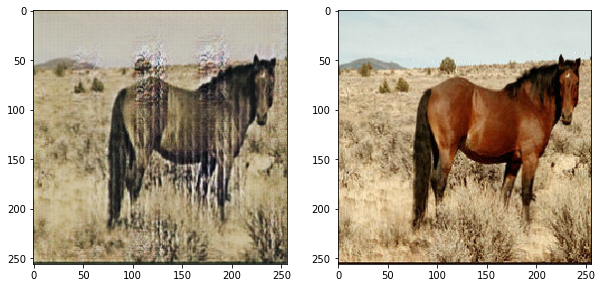

In [12]:
img = next(iter(train_horses)).numpy()

predicted = G.predict(img)[0] * 127.5 + 127.5
predicted = predicted.astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(predicted)
ax[1].imshow((img[0] * 127.5 + 127.5).astype(np.uint8))
plt.show()